In [ ]:
# %pip install opencv-python-headless numpy scikit-learn tensorflow

In [ ]:
# Restart the runtime
# !kill -9 -1

In [1]:
from google.colab import drive  # 40s

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# 1. Import Libraries 5s
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# 2. Dataset Loading

dataset_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/mini_dataset"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# Get the class names (disease names)
class_names = os.listdir(train_dir)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 6
Class names: ['early_leaf_spot', 'early_rust', 'healthy_leaf', 'late_leaf_spot', 'rust', 'nutrition_deficiency']


In [4]:
import os

def count_images_in_subfolders(folder_path):
    image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}  # Common image formats
    folder_image_counts = {}

    # Loop through each subfolder inside the given folder
    for sub_folder in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, sub_folder)

        if os.path.isdir(sub_folder_path):  # Ensure it's a folder
            image_count = sum(1 for file in os.listdir(sub_folder_path)
                              if os.path.splitext(file)[1].lower() in image_extensions)
            folder_image_counts[sub_folder] = image_count

    return folder_image_counts

# Example usage
folder_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/mini_dataset/test"
folder_counts = count_images_in_subfolders(folder_path)

# Print results
for folder_name, count in folder_counts.items():
    print(f"Folder '{folder_name}' has {count} images.")

Folder 'early_leaf_spot' has 60 images.
Folder 'early_rust' has 60 images.
Folder 'late_leaf_spot' has 60 images.
Folder 'nutrition_deficiency' has 60 images.
Folder 'rust' has 60 images.
Folder 'healthy_leaf' has 60 images.


In [5]:
# 3. Data Preprocessing (6m for 2160 imgs)

images = []
labels = []

for split_dir in [train_dir, test_dir]:
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith((".jpg", ".png", ".jpeg")):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize

                    height, width = img.shape[:2]
                    size = min(height, width)
                    x = (width - size) // 2
                    y = (height - size) // 2
                    img = img[y : y + size, x : x + size]

                    original_shape = img.shape
                    image_2d = img.reshape(-1, 3)
                    scaler = MinMaxScaler(feature_range=(0, 1))
                    normalized_2d = scaler.fit_transform(image_2d)
                    normalized_image = normalized_2d.reshape(original_shape)

                    images.append(normalized_image)
                    labels.append(class_name)
                else:
                    print(f"Error reading image: {img_path}")

images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(2160, 224, 224, 3)
(2160,)


In [6]:
# 4. Label Encoding
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
print(labels_encoded)
print(set(labels_encoded))

[0 0 0 ... 4 4 4]
{0, 1, 2, 3, 4, 5}


In [7]:
# 5. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Train data shape: (1728, 224, 224, 3)
Validation data shape: (216, 224, 224, 3)
Test data shape: (216, 224, 224, 3)


In [8]:
model = tf.keras.models.Sequential(   # 3s
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(224, 224, 3)
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# 7. Model Training # 1m
epochs = 30
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.2047 - loss: 2.2201 - val_accuracy: 0.4676 - val_loss: 1.1679
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5204 - loss: 1.1353 - val_accuracy: 0.6944 - val_loss: 0.7601
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7210 - loss: 0.7769 - val_accuracy: 0.8796 - val_loss: 0.3670
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8390 - loss: 0.4604 - val_accuracy: 0.9167 - val_loss: 0.2609
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8856 - loss: 0.3081 - val_accuracy: 0.9306 - val_loss: 0.2004
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9155 - loss: 0.2622 - val_accuracy: 0.9213 - val_loss: 0.1908
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9337 - loss: 0.1986 - val_accuracy: 0.9167 - val_loss: 0.2117
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9545 - loss: 0.1466 - val_accuracy: 0.9398 -

In [10]:
# 8. Model Evaluation:

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss * 100}")
print(f"Test Accuracy: {accuracy * 100}")

Test Loss: 17.70145148038864
Test Accuracy: 96.75925970077515


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = model.predict(X_test)

y_pred_classes = y_pred.argmax(axis=-1)
y_true = y_test

precision = precision_score(y_true, y_pred_classes, average='weighted')  # For multi-class classification
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Precision: 0.9688
Recall: 0.9676
F1-Score: 0.9675
Accuracy: 96.76%


In [22]:
# 7. Saving the Model and Label Encoder:

import pickle
models_dir = "/content/drive/MyDrive//Projects/Plant Disease Prediction/saved_models"
os.makedirs(models_dir, exist_ok=True)

model_save_path = os.path.join(models_dir, "96acc_groundnut_disease_model.keras")
model.save(model_save_path)

le_save_path = os.path.join(models_dir, "label_encoder.pkl")

with open(le_save_path, "wb") as f:
    pickle.dump(le, f)

# print(f"Model saved to: {model_save_path}")
print(f"Label encoder saved to: {le_save_path}")

Label encoder saved to: /content/drive/MyDrive//Projects/Plant Disease Prediction/saved_models/label_encoder.pkl


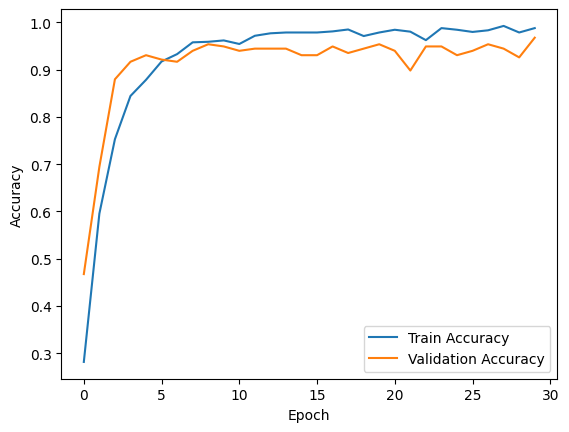

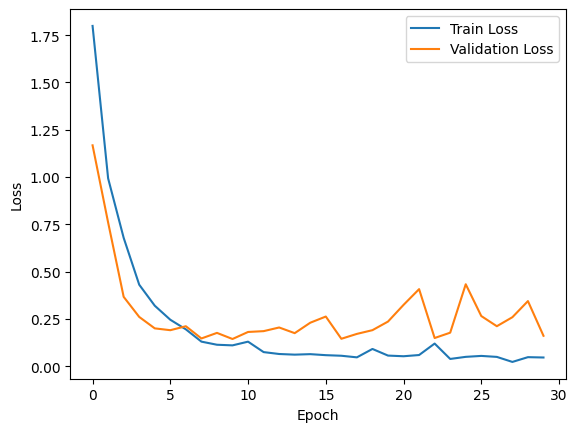

In [32]:
# 9. Plotting Training History

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import MinMaxScaler

def preprocess_image(img_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to (224, 224)
    height, width = img.shape[:2]
    size = min(height, width)
    x = (width - size) // 2
    y = (height - size) // 2
    img = img[y : y + size, x : x + size]  # Crop image to square

    # Normalize the image
    original_shape = img.shape
    image_2d = img.reshape(-1, 3)
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_2d = scaler.fit_transform(image_2d)
    normalized_image = normalized_2d.reshape(original_shape)

    # Add an extra dimension for batch size (1 image in this case)
    normalized_image = np.expand_dims(normalized_image, axis=0)

    return normalized_image

# Path to the input image
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/nutrition_deficiency_1/dr_4_9961.jpg"
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/late_leaf_spot_1/dr_4_9915.jpg"
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/rust_1/IMG_9015.jpg"
img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/healthy_leaf_1/dr_4_1013.jpg"

# Preprocess the image
input_img = preprocess_image(img_path)

# Make prediction
predictions = model.predict(input_img)
predicted_class = np.argmax(predictions)  # Get class with highest probability
confidence = np.max(predictions)  # Get confidence score

print(f"Predicted Class: {predicted_class}, Confidence: {confidence * 100:.2f}%")

import pickle

# Load label encoder
le_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/saved_models/label_encoder.pkl"
with open(le_path, "rb") as f:
    le = pickle.load(f)

# Get the disease name
predicted_label = le.inverse_transform([predicted_class])[0]
print(f"Predicted Disease: {predicted_label}, Confidence: {confidence * 100:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Class: 2, Confidence: 99.96%
Predicted Disease: healthy_leaf, Confidence: 99.96%
